In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset 
import numpy as np
from torch.utils.tensorboard import SummaryWriter


C:\Users\dell\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\dell\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\dell\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please upd

## preparing the data using PyTorch
    1. extract-get the data from Fashion MNIST IMAGE DATA 
    2. Transform put the data in a tensor 
    3. Load- put the data into an object to make it accessible


In [ ]:
# this piece of code is unnecessary if we're using a standard dataset already available in torchvision.datasets 
# but its a great example to show whats happening under the hood in pytorch
# to create a dataset in pytorch we need to extend the torch.utils.data.Dataset class
# and implement the following methods:

class OHLC(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
    def __getitem__(self,index):
        r = self.data.iloc[index]
        label = torch.tensor(r.is_up_day, dtype=torch.long)
        sample = self.normalize(torch.tensor([r.open, r.high, r.low, r.close]))
        return sample,label
    def __len__(self):
        return len(self.data)
# we can create a dataset object by passing the csv file as an argument to the constructor
# and then we can use the dataset object to create a dataloader object by passing it to the DataLoader class
# and then we can use the dataloader object to iterate over the dataset in batches.
# we can also use the dataloader object to get the number of samples in the dataset.
# we can also use the dataloader object to get the number of batches in the dataset


In [2]:
# we're going to ETL the Fashion MNIST dataset

train_set = datasets.FashionMNIST(
    root="./data/FashionMNIST",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()])
)
train_loader = DataLoader(train_set,batch_size=10)

In [3]:
# in our case the dataset is balanced as the bins have equal number of samples
# but if we encounter a case of unbalanced dataset then we can use oversampling and undersampling techniques and stratified sampling
# we can also use a combination of these techniques to get a balanced dataset 
# it might be a burden on memory but it yields better resutls 

torch.set_printoptions(linewidth=120)
len(train_set)
print(train_set.targets) # targets are the labels of the train data
train_set.targets.bincount()
# we can see that the bins are balanced

tensor([9, 0, 0,  ..., 3, 0, 5])


tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

regarding the paper 
**" A systematic study of the class imbalance problem in convolutional neural networks"** by
https://arxiv.org/abs/1710.05381

i quote from the paper : "Regarding performance of different methods for addressing imbalance, in almost all of the situations oversampling emerged as the best method."


In [4]:
# Accessing data in the training set
# we use the python built in function iter(),which returns an object representing a stream of data.
# The function next() takes this object and returns the next value from the stream.
# We can use this to iterate over the data
# we get 2 because the data is a tuple of 2 elements, a pair of image and its label

sample = next(iter(train_set))
print(len(sample))

# we can destruct it or sequence unpacking 
image = sample[0]
label = sample[1]


2


label: 9


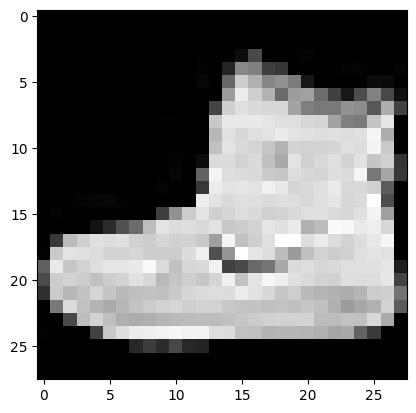

In [5]:
plt.imshow(image.squeeze(), cmap='gray')
print('label:',label)
plt.show()

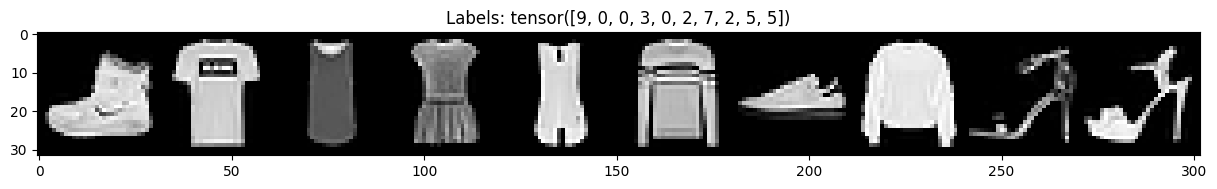

In [6]:
batch= next(iter(train_loader))
images, labels = batch

grid= torchvision.utils.make_grid(images,nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
plt.title("Labels: "+ str(labels))
plt.show()

In [7]:
class Network(nn.Module): 
    def __init__(self,channels=1):
        super().__init__()
        # PyTorch's nn.Module class keeps tracks of the wieghts tensors and biases inside each layer, so we pass them as arguments to the constructor
        # sets in_channels is for the color channels, if we're working with non linear layers out_channels is the number of filters; one filter gives one output channel/ features , if we're working with linear layers we out_feature sets the size of the output tensor, kernel_size is the size of the kernel/ convolutional filter
        # one common thing when building CNN layers is to increase the number of out_channels as we go through the layers, and decrease the number of out_features as we go through linear layers
 
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=6, kernel_size=5) # 2 convolutional layers 
        # Second conv with padding=2 to maintain dimensions after pooling
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5) # we add a stride that is now 1 by default, to tell the filter how many units to move up and down 
        # 3 fully connected layers/ linear layers/ dense layers
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120) # when we switch from convolutional layers to linear layers we need to flatten the output of the convolutional layers this is why we have 12*4*4 , the 12 is the number of output channels from the second convolutional layer, 4*4 means output of the last CNN is 4x4 image/filter:outputSizeOfCov = [(inputSize + 2*pad - filterSize)/stride] + 1
        self.fc2 = nn.Linear(in_features=120, out_features=60)# in_features depend on the previous layer's out_features
        self.out = nn.Linear(in_features=60, out_features=10) # 10 out_features here are the predicted classes, in this case 10 classes for the Fashion MNIST dataset
# Note: in linear layers by default the bias is set to True 
# All filters are represented using a single tensor.
# Filters have depth that accounts for the input channels.
# conv weight tensors are of rank 4 (numbers of filters, in_channels, height, width)
# linear weight tensors are of rank 2 (out_features,in_features) (H,W) 
    def forward(self, t):
        # (1) input layer
        t = t
        
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t) # activation_function='relu' in tf.keras      
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t) # activation_funcion='relu' in tf.keras
        
        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        
        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1) # first index is batch
        return t
    
    #def __repr__(self): # just an example pn some Python OOP that u may help u when debugging
    #    return "this overrides the official string representation of the object" 

In [8]:
# initialize a network
network = Network() 

def get_num_correct(preds, labels):
    return (preds.argmax(dim=1) == labels).sum()

F.cross_entropy(torch.tensor([[3, 6, 2], [1, 1, 2]]).float(), torch.tensor([2, 1]))

softmax = lambda a: np.exp(a) / np.exp(a).sum()

(-np.log(softmax(np.array([3,6,2])))[2] + -np.log(softmax(np.array([1,1,2])))[1])/2 # averages

optimizer = optim.Adam(network.parameters(), lr=0.01) # optimizer has access to network parameters

network.conv1.weight.grad is None
preds = network(images)
loss = F.cross_entropy(preds, labels) 

print('loss: ', loss) 
print('no. correct:', get_num_correct(preds, labels)) # out of 100

loss.backward() # backprop, looks at definition of loss and crawls backward into the network
network.conv1.weight.grad.shape # gradients updated after one pass of backprop

loss:  tensor(2.3167, grad_fn=<NllLossBackward0>)
no. correct: tensor(1)


torch.Size([6, 1, 5, 5])

In [9]:
optimizer.step() # based on our new loss gradient values, we update weights accdg to Adam to minimize loss.

preds = network(images) # run new predictions
loss = F.cross_entropy(preds, labels) 
print('loss after backprop: ', loss, 'no. correct:', get_num_correct(preds, labels))

loss after backprop:  tensor(2.2388, grad_fn=<NllLossBackward0>) no. correct: tensor(2)


In [10]:
#Training one batch

# compile the neural net
network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.01)


# loss
loss = F.cross_entropy(network(images), labels)
print("Step 0:")
print(loss.item())
print(get_num_correct(network(images), labels))

# backprop
loss.backward()  # update gradients
optimizer.step() # update weights using gradients to minimize loss

# recalculating loss based on new weights
loss = F.cross_entropy(network(images), labels)
print("\nStep 1:")
print(loss.item())
print(get_num_correct(network(images), labels))

Step 0:
2.350571393966675
tensor(0)

Step 1:
2.2857930660247803
tensor(2)


In [13]:
#Training a single epoch

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100) 

network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.01)

total_loss = 0
total_correct = 0
for batch in train_loader:
    images, labels = batch 

    preds = network(images) 
    loss = F.cross_entropy(preds, labels) 

    optimizer.zero_grad() 
    loss.backward()  # calculate gradients
    optimizer.step() # update weights using gradients using adam

    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)
    
print(
    "epoch:", 0, 
    "total_correct:", total_correct, 
    "loss:", total_loss
)

epoch: 0 total_correct: tensor(45379) loss: 380.0166459083557


In [15]:
if network.conv1.weight.grad is not None:
    print(network.conv1.weight.grad.sum())
else:
    print("No gradients computed yet")


tensor(1.1998)


In [16]:
#Training with multiple epochs
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)

network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(10):    
    total_loss = 0
    total_correct = 0
    
    for batch in train_loader:    
        images, labels = batch 
        preds = network(images)
        loss = F.cross_entropy(preds, labels) # check that loss tensor has a gradient attribute
                                              # so that line 17 makes sense
        optimizer.zero_grad() # set all gradients to zero
        loss.backward() # calculate gradient
        optimizer.step() # update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: tensor(47719) loss: 324.959082454443
epoch 1 total_correct: tensor(51605) loss: 224.59134384989738
epoch 2 total_correct: tensor(52353) loss: 205.31755885481834
epoch 3 total_correct: tensor(52815) loss: 195.77987752854824
epoch 4 total_correct: tensor(52925) loss: 189.5943547040224
epoch 5 total_correct: tensor(53135) loss: 184.88502830266953
epoch 6 total_correct: tensor(53212) loss: 183.10018488764763
epoch 7 total_correct: tensor(53416) loss: 177.53898786008358
epoch 8 total_correct: tensor(53282) loss: 179.6652434170246
epoch 9 total_correct: tensor(53448) loss: 177.2940489128232


train accuracy is 53448/60000 (0.891)

### **TensorBoard: TensorFlow's Visualization Toolkit**
TensorBoard provides the visualization and tooling needed for machine learning experimentation:

    1. Tracking and visualizing metrics such as loss and accuracy
    2. Visualizing the model graph (ops and layers)
    3. Viewing histograms of weights, biases, or other tensors as they change over time
    4. Projecting embeddings to a lower dimensional space
    5. Displaying images, text, and audio data
    6. Visualizing the execution of a TensorFlow graph
    7. Visualizing a TensorFlow program's execution
    8. Profiling TensorFlow programs
    And much more

In [19]:
print(torch.__version__)
!tensorboard --version

2.7.1+cpu


C:\Users\dell\AppData\Roaming\Python\Python313\site-packages\tensorboard\default.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\dell\AppData\Roaming\Python\Python313\Scripts\tensorboard.exe\__main__.py", line 4, in <module>
    from tensorboard.main import run_main
  File "C:\Users\dell\AppData\Roaming\Python\Python313\site-packages\tensorboard\main.py", line 27, in <module>
    from tensorboard import default
  File "C:\Users\dell\AppData\Roaming\Python\Python313\site-packages\tensorboard\default.py", line 40, in <module>
    from tensorboard.plugins.image import images_plugin
  File "C:\Users\dell\AppData\Roa

In [25]:

tb = SummaryWriter()
network = Network()

images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)
tb.add_image('images', grid)
tb.add_graph(network, images)

tb.close()

In [26]:




# Compile network
network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.001)

# Initialize tensorboard
tb = SummaryWriter() # from torch.utils.tensorboard import SummaryWriter

# Training
for epoch in range(10): 
    total_loss = 0
    total_correct = 0
    
    for batch in train_loader:
        images, labels = batch 
        preds = network(images)
        
        loss = F.cross_entropy(preds, labels) # loss function
        optimizer.zero_grad()                 # set all gradients to zero
        
        loss.backward()         # calculate gradients, training points are supply constants
        optimizer.step()        # update weights to minimize loss (accdg to adam)

        total_loss += loss.item() 
        total_correct += get_num_correct(preds, labels)
    
    tb.add_scalar('Loss', total_loss, epoch)
    tb.add_scalar('Number Correct', total_correct, epoch)
    tb.add_scalar('Accuracy', total_correct / len(train_set), epoch)
    
    tb.add_histogram('conv1.bias', network.conv1.bias, epoch)
    tb.add_histogram('conv1.weight', network.conv1.weight, epoch)
    tb.add_histogram('conv1.weight.grad', network.conv1.weight.grad, epoch)
    print("epoch", epoch, "train_acc", total_correct / 60000, "loss:", total_loss)

tb.close()

epoch 0 train_acc tensor(0.6970) loss: 477.0766302347183
epoch 1 train_acc tensor(0.8063) loss: 307.8935236334801
epoch 2 train_acc tensor(0.8407) loss: 260.4904620051384
epoch 3 train_acc tensor(0.8589) loss: 231.5982717424631
epoch 4 train_acc tensor(0.8694) loss: 213.44451256096363
epoch 5 train_acc tensor(0.8774) loss: 199.79611791670322
epoch 6 train_acc tensor(0.8840) loss: 189.5195411592722
epoch 7 train_acc tensor(0.8889) loss: 181.08475697040558
epoch 8 train_acc tensor(0.8936) loss: 173.766216263175
epoch 9 train_acc tensor(0.8964) loss: 168.2620684877038


In [27]:


def train(lr, batch_size, shuffle, num_epochs=5):
    # data loader
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)

    # compile network
    network = Network()
    optimizer = optim.Adam(network.parameters(), lr=lr)

    # Initialize tensorboard
    tb = SummaryWriter(comment=f' lr={lr} batch_size={batch_size} shuffle={shuffle}') # this is appended
    
    # Training
    print('\nlr=', lr, 'batch_size=', batch_size, 'shuffle=', shuffle)
    for epoch in range(num_epochs): 
        total_loss = 0
        total_correct = 0

        for batch in train_loader:
            images, labels = batch 
            preds = network(images)

            loss = F.cross_entropy(preds, labels) 
            
            optimizer.zero_grad()                 
            loss.backward()         
            optimizer.step()        

            total_loss += loss.item()*batch_size             # get absolute loss 
            total_correct += get_num_correct(preds, labels)

        tb.add_scalar('Loss', total_loss, epoch)
        tb.add_scalar('Number Correct', total_correct, epoch)
        tb.add_scalar('Accuracy', total_correct / len(train_set), epoch)

        tb.add_histogram('conv1.bias', network.conv1.bias, epoch)
        tb.add_histogram('conv1.weight', network.conv1.weight, epoch)
        tb.add_histogram('conv1.weight.grad', network.conv1.weight.grad, epoch)

        print("epoch", epoch, "\t train_acc", total_correct / len(train_set), "\t loss:", total_loss)

    tb.close()

In [28]:
import tensorflow

tensorflow.__version__

'2.20.0-dev20250708'

In [29]:
lr_list = [0.1, 0.01, 0.001]
batch_size_list = [10, 100, 1000]
shuffle_list = [True, False]

# hyperparameter grid search
for param in product(lr_list, batch_size_list, shuffle_list):
    train(*param, num_epochs=10)


lr= 0.1 batch_size= 10 shuffle= True
epoch 0 	 train_acc tensor(0.1026) 	 loss: 140034.82088804245
epoch 1 	 train_acc tensor(0.0992) 	 loss: 139563.37186574936
epoch 2 	 train_acc tensor(0.0997) 	 loss: 139587.29279994965
epoch 3 	 train_acc tensor(0.1014) 	 loss: 139564.21141147614
epoch 4 	 train_acc tensor(0.0997) 	 loss: 139527.795317173
epoch 5 	 train_acc tensor(0.1015) 	 loss: 139481.81215763092
epoch 6 	 train_acc tensor(0.0994) 	 loss: 139517.7787733078
epoch 7 	 train_acc tensor(0.0973) 	 loss: 139589.9741768837
epoch 8 	 train_acc tensor(0.1000) 	 loss: 139563.27685117722
epoch 9 	 train_acc tensor(0.1000) 	 loss: 139540.8569598198

lr= 0.1 batch_size= 10 shuffle= False
epoch 0 	 train_acc tensor(0.1021) 	 loss: 139658.3265209198
epoch 1 	 train_acc tensor(0.1021) 	 loss: 139448.97980213165
epoch 2 	 train_acc tensor(0.1021) 	 loss: 139448.97879838943
epoch 3 	 train_acc tensor(0.1021) 	 loss: 139448.9786529541
epoch 4 	 train_acc tensor(0.1021) 	 loss: 139448.978703022
ep

### **Remarks:**

For a large learning rate 0.1, the model does not improve beyond 10% accuracy.
We can imitate the sklearn API and define .fit(self, dataset, lr, batch_size, shuffle, num_epochs) inside an instance of the network.

### **Summary: End-to-end use.**
The SummaryWriter object writes to the runs folder information regarding what are written to it during training. TensorBoard then accesses these log files. The interface can be viewed by entering tensorboard --logdir=runs in Terminal.

- Import from torch.utils.tensorboard import SummaryWriter
- Initialize tb = SummaryWriter()
- Write using tb.add_scalar, tb.add_histogram, comments, etc.
- Close the writer, tb.close()
- View the interface from the terminal tensorboard --logdir=runs.

**Early-stopping**
We can set a prev_loss variable to save the last loss value calculated (best done for validation loss). If the loss increases beyond a set tolerance (the network starts overfitting), we stop the training.

In [30]:

class Network(nn.Module):
    def __init__(self, channels=1): # default grayscale
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=6, kernel_size=5) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120) # ((28-5+1)/2 -5 +1)/2 = 4
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) input layer
        t = t
        
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t) # activation_function='relu' in tf.keras      
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t) # activation_funcion='relu' in tf.keras
        
        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        
        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1) # first index is batch
        return t


def get_num_correct(preds, labels):
    return (preds.argmax(dim=1) == labels).sum()


# Get data

# Compile network
network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.01)


# Train for 10 epochs
for epoch in range(10): 
    total_loss = 0
    total_correct = 0
    
    for batch in train_loader:
        images, labels = batch 
        preds = network(images)
        
        loss = F.cross_entropy(preds, labels) # loss function
        optimizer.zero_grad()                 # set all gradients to zero
        
        loss.backward()         # calculate gradients, training points are supply constants
        optimizer.step()        # update weights to minimize loss (accdg to adam)

        total_loss += loss.item() 
        total_correct += get_num_correct(preds, labels)
        
    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: tensor(45402) loss: 379.31063798069954
epoch 1 total_correct: tensor(50253) loss: 263.45164558291435
epoch 2 total_correct: tensor(51114) loss: 238.57917414605618
epoch 3 total_correct: tensor(51582) loss: 227.86232540011406
epoch 4 total_correct: tensor(51766) loss: 221.73263746500015
epoch 5 total_correct: tensor(51872) loss: 219.1599306613207
epoch 6 total_correct: tensor(52094) loss: 213.07448703050613
epoch 7 total_correct: tensor(52135) loss: 213.0996966511011
epoch 8 total_correct: tensor(52286) loss: 208.63510642945766
epoch 9 total_correct: tensor(52338) loss: 206.93188540637493


In [33]:
@torch.no_grad()
def get_all_preds_labels(model, loader): # simple concat
    all_preds  = torch.tensor([])
    all_labels = torch.tensor([])
    for batch in loader:
        images, labels = batch
        all_preds  = torch.cat((all_preds,  model(images)),  dim=0)
        all_labels = torch.cat((all_labels, labels.float()), dim=0)
    return all_preds, all_labels


with torch.no_grad(): # disable gradient tracking!
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=60000)
    train_preds, train_labels = get_all_preds_labels(network, train_loader)



In [34]:
train_preds.shape # predictions in the form of probability dists


torch.Size([60000, 10])

In [35]:
train_labels.shape


torch.Size([60000])

In [ ]:
train_preds.argmax(dim=1).shape

In [36]:
def confusion_matrix(y_true, y_pred):
    C = np.zeros((10, 10), dtype=int)
    for k in range(len(y_true)):
        i = actual[k]   
        j = predicted[k]
        C[i, j] += 1
    return C




In [37]:
actual    = train_labels.int().numpy()
predicted = train_preds.argmax(dim=1).int().numpy()


In [38]:
import sklearn
(confusion_matrix(actual, predicted) == 
 sklearn.metrics.confusion_matrix(actual, predicted)).all()

np.True_

In [39]:
C = confusion_matrix(actual, predicted)

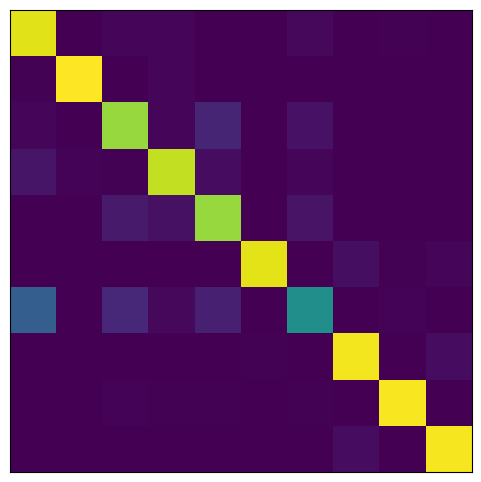

In [ ]:

%matplotlib inline

# simple man plot
plt.figure(figsize=(6,6))
plt.imshow(C)
plt.xticks([])
plt.yticks([]);

In [41]:
np.array(C/60, dtype=int)

array([[93,  0,  1,  1,  0,  0,  2,  0,  0,  0],
       [ 0, 97,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 1,  0, 82,  1,  9,  0,  4,  0,  0,  0],
       [ 5,  0,  0, 88,  3,  0,  1,  0,  0,  0],
       [ 0,  0,  7,  4, 82,  0,  5,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 93,  0,  3,  0,  1],
       [29,  0, 11,  1,  8,  0, 48,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 96,  0,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 96,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  3,  0, 96]])

Confusion matrix, without normalization
[[5596   22  107  102   16    3  126    0   28    0]
 [  31 5863    3   87    5    0    6    0    5    0]
 [  78    8 4955   73  596    0  281    0    9    0]
 [ 331   52   25 5320  184    0   88    0    0    0]
 [  13   11  432  260 4961    0  315    0    8    0]
 [   2    2    0    1    0 5627    2  226   36  104]
 [1750   13  667  119  507    0 2895    0   49    0]
 [   2    0    0    0    0   35    0 5762   16  185]
 [  22    6   54   30   31   10   36    4 5804    3]
 [   0    3    1    2    0   13    2  198    5 5776]]


NameError: name 'matplotlib' is not defined

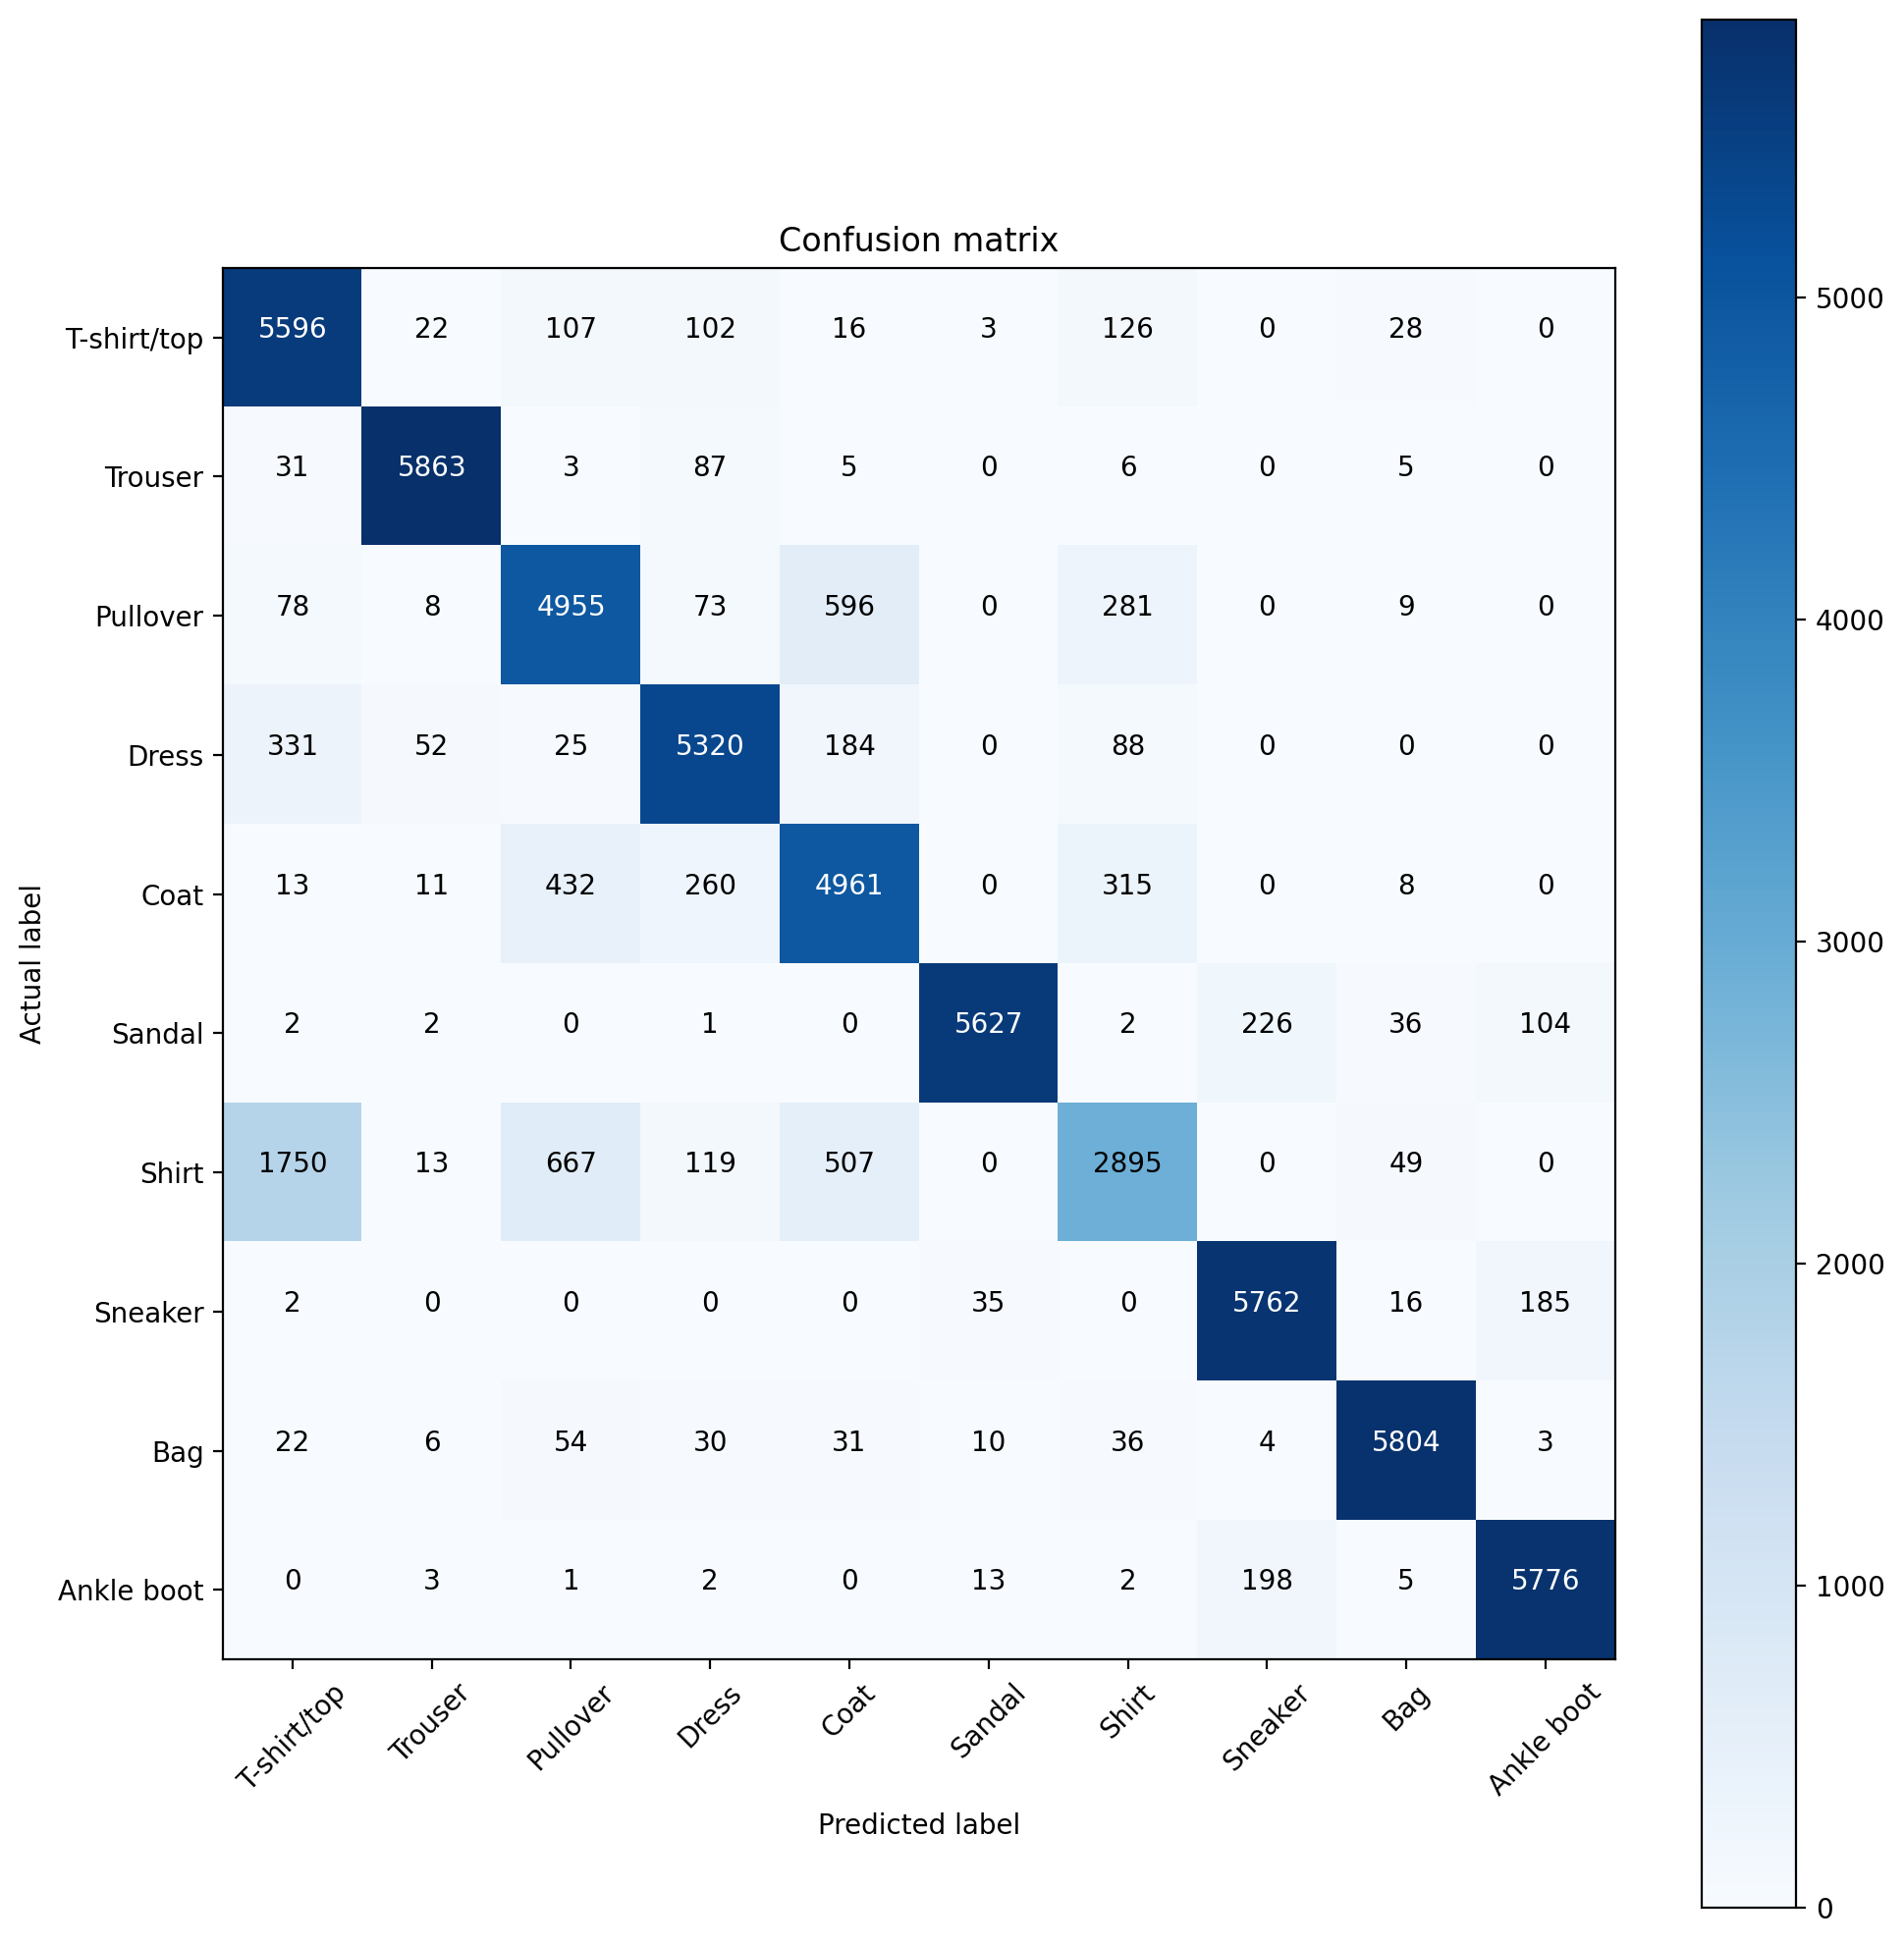

In [44]:
import itertools

import seaborn as sns


def plot_confusion_matrix(cm, classes, 
                          normalize=False, 
                          title='Confusion matrix', 
                          cmap=plt.cm.Blues):
    
    # print the cm
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    # plot the cm
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd' # float or int
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black") # color of text

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    

names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)
plt.figure(figsize=(10,10), dpi=200)
plot_confusion_matrix(C, names)
if matplotlib.__version__ == '3.1.1':
    axes = plt.gca()
    a = axes.get_ylim()
    plt.ylim(a[1]-0.5, a[0]+0.5)